# Predict Calorie Expenditure

## Importing libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb
import catboost as cat

In [2]:
SEED = 42
N_SPLITS = 5

## Defining RMSLE

In [3]:
def rmsle_score(y, preds):
    y = np.maximum(0, y)
    preds = np.maximum(0, preds)
    return np.sqrt(np.mean((np.log1p(preds) - np.log1p(y)) ** 2))

## Data loading

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [5]:
train.shape

(750000, 9)

In [6]:
train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [7]:
train = train.drop('id',axis=1)
train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


## EDA

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Sex         750000 non-null  object 
 1   Age         750000 non-null  int64  
 2   Height      750000 non-null  float64
 3   Weight      750000 non-null  float64
 4   Duration    750000 non-null  float64
 5   Heart_Rate  750000 non-null  float64
 6   Body_Temp   750000 non-null  float64
 7   Calories    750000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 45.8+ MB


In [9]:
train.isna().sum()

Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [10]:
train['Sex'].unique()

array(['male', 'female'], dtype=object)

<Axes: xlabel='Body_Temp', ylabel='Count'>

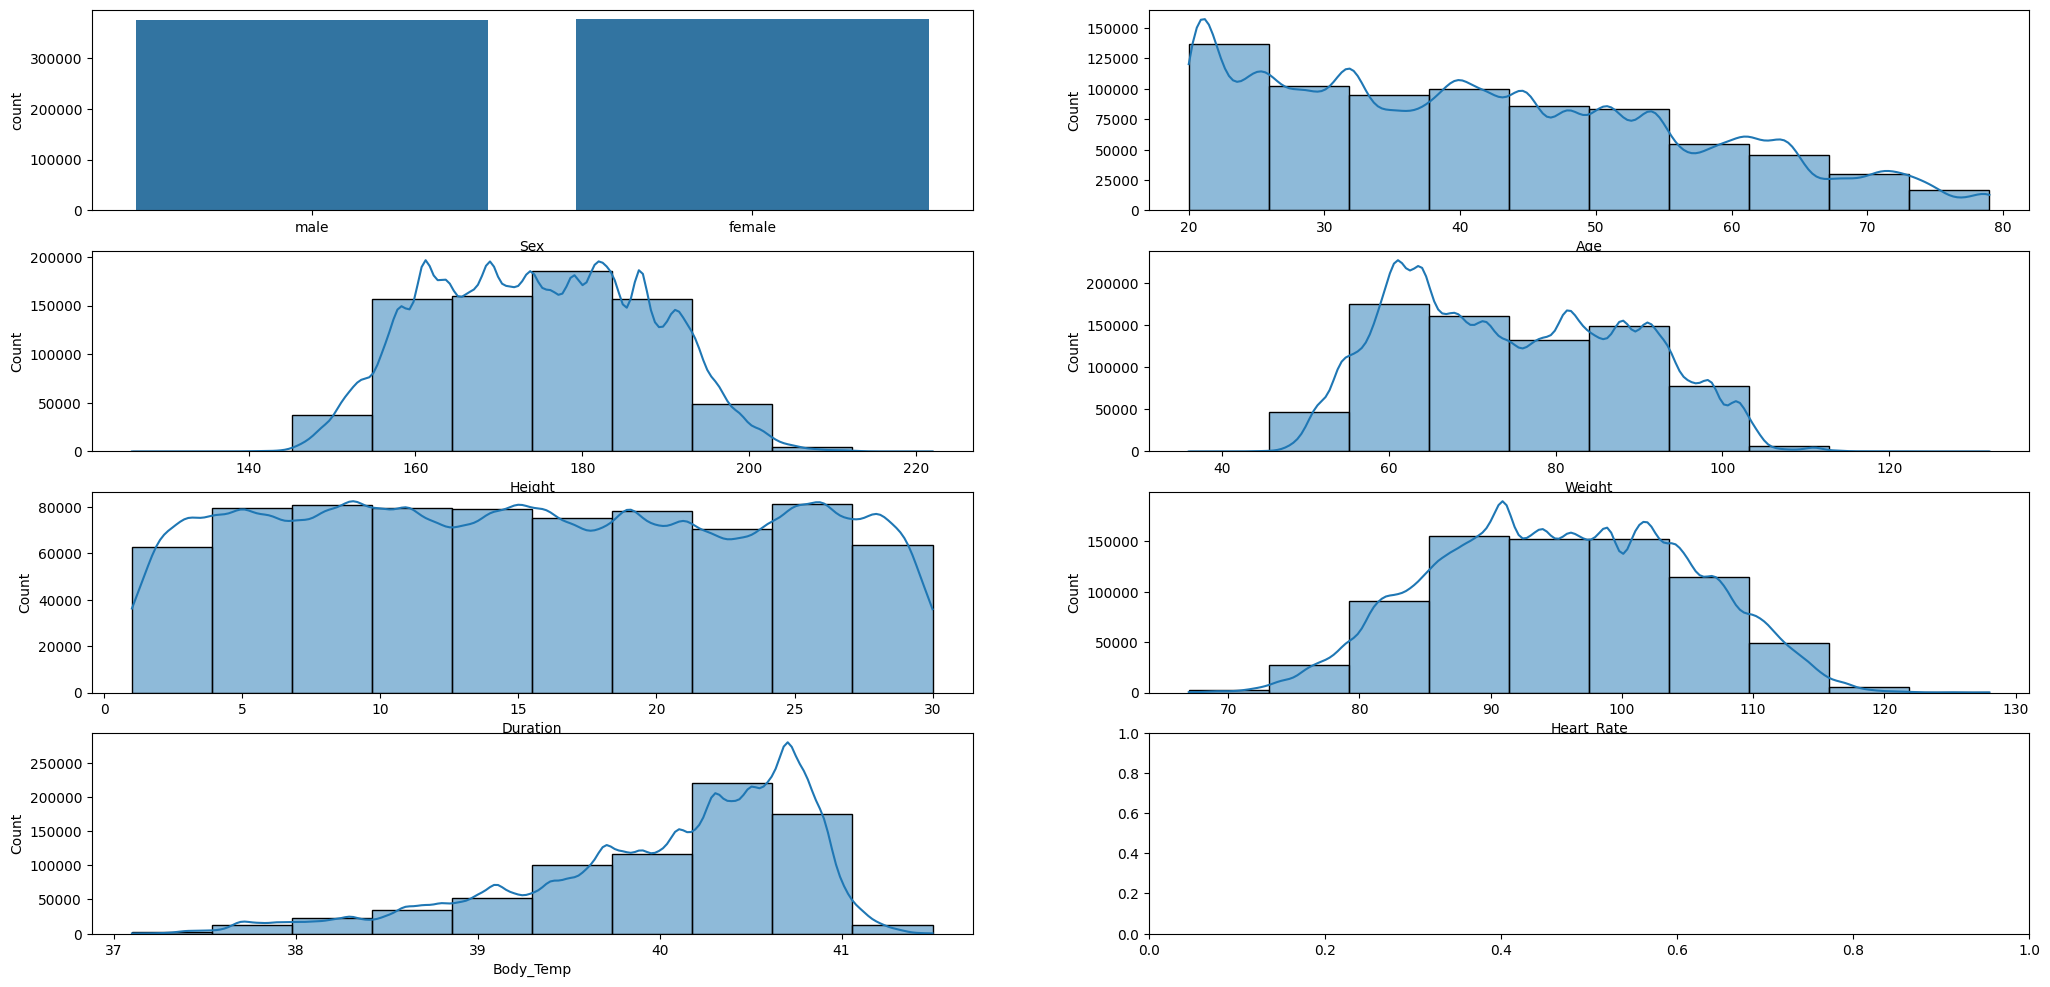

In [11]:
fig,ax = plt.subplots(4,2,figsize=(25,12))
sns.countplot(x = 'Sex', data = train,ax = ax[0,0])
sns.histplot(x='Age',data=train,bins=10,kde=True,ax = ax[0,1])
sns.histplot(x='Height',data=train,bins=10,kde=True,ax = ax[1,0])
sns.histplot(x='Weight',data=train,bins=10,kde=True,ax = ax[1,1])
sns.histplot(x='Duration',data=train,bins=10,kde=True,ax = ax[2,0])
sns.histplot(x='Heart_Rate',data=train,bins=10,kde=True,ax = ax[2,1])
sns.histplot(x='Body_Temp',data=train,bins=10,kde=True,ax = ax[3,0])

## Correlation matrix

In [12]:
corr_data_col = [col for col in train.columns if col not in ['id','Sex']]
corr= train[corr_data_col].corr()
print(corr)

                 Age    Height    Weight  Duration  Heart_Rate  Body_Temp  \
Age         1.000000  0.011975  0.073690  0.015656    0.017037   0.030275   
Height      0.011975  1.000000  0.957967 -0.029936   -0.013234  -0.034641   
Weight      0.073690  0.957967  1.000000 -0.020845   -0.002384  -0.023717   
Duration    0.015656 -0.029936 -0.020845  1.000000    0.875327   0.903066   
Heart_Rate  0.017037 -0.013234 -0.002384  0.875327    1.000000   0.795972   
Body_Temp   0.030275 -0.034641 -0.023717  0.903066    0.795972   1.000000   
Calories    0.145683 -0.004026  0.015863  0.959908    0.908748   0.828671   

            Calories  
Age         0.145683  
Height     -0.004026  
Weight      0.015863  
Duration    0.959908  
Heart_Rate  0.908748  
Body_Temp   0.828671  
Calories    1.000000  


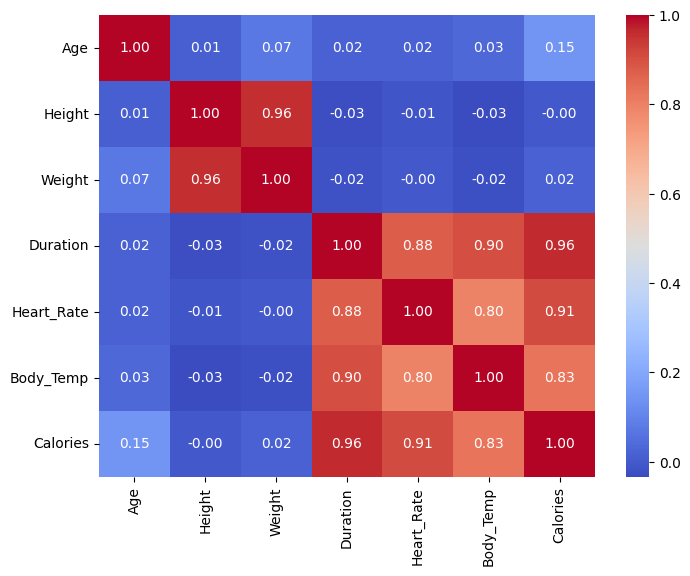

In [13]:
# show the heatmap of the correlation matrix:
plt.figure(figsize=(8,6))
sns.heatmap(corr,annot=True,cmap='coolwarm',fmt='.2f')
plt.show()

## Preprocessing data

In [14]:
bins = list(np.arange(1, 40, 5))
labels = [f'{b}-{b+4}' for b in bins[:-1]]

train['Duration_class'] = pd.cut(train['Duration'], bins=bins, labels=labels, right=False)
test['Duration_class'] = pd.cut(test['Duration'], bins=bins, labels=labels, right=False)

In [15]:
train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Duration_class
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0,26-30
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0,6-10
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0,6-10
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0,21-25
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0,21-25


In [16]:
group_encod = train.groupby(['Sex', 'Duration_class'])['Calories'].median().reset_index()
group_encod.rename(columns={'Calories': 'Calories_encoded'}, inplace=True)

train = train.merge(group_encod, on=['Sex', 'Duration_class'], how='left')
test= test.merge(group_encod, on=['Sex', 'Duration_class'], how='left')

/tmp/ipykernel_3673/1448204574.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_encod = train.groupby(['Sex', 'Duration_class'])['Calories'].median().reset_index()


In [17]:
from sklearn.preprocessing import OneHotEncoder

cat_cols = ['Duration_class', 'Sex']
encoder = OneHotEncoder(sparse_output=False, drop=None, handle_unknown='ignore')


encoded_train = encoder.fit_transform(train[cat_cols])
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(cat_cols))
train = pd.concat([train.drop(columns=cat_cols), encoded_train_df], axis=1)


encoded_test = encoder.transform(test[cat_cols])
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(cat_cols))
test= pd.concat([test.drop(columns=cat_cols), encoded_test_df], axis=1)



train['BMI'] = train['Weight']/((train['Height']/100)**2)
test['BMI']= test['Weight']/((test['Height']/100)**2)



In [26]:
train.head()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Calories_encoded,Duration_class_1-5,Duration_class_11-15,Duration_class_16-20,Duration_class_21-25,Duration_class_26-30,Duration_class_6-10,Sex_female,Sex_male,BMI
0,36,189.0,82.0,26.0,101.0,41.0,150.0,194.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,22.955684
1,64,163.0,60.0,8.0,85.0,39.7,34.0,35.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,22.582709
2,51,161.0,64.0,7.0,84.0,39.8,29.0,35.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,24.690405
3,20,192.0,90.0,25.0,105.0,40.7,140.0,141.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,24.414062
4,38,166.0,61.0,25.0,102.0,40.6,146.0,137.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,22.136740


In [19]:
X = train.drop(columns=["Calories"])
y = train["Calories"]

## XGB

In [20]:
params = {
    "objective": "reg:squarederror",
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    "learning_rate": 0.05,
    "max_depth": 7,
    "n_estimators": 1000,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "random_state": 42,
    "verbosity": 0
}

In [21]:
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

scores = []
models = []

for fold, (train_index, valid_index) in enumerate(kf.split(X), 1):
    X_train, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_val = y.iloc[train_index], y.iloc[valid_index]

    model = xgb.XGBRegressor(
        **params,
        early_stopping_rounds=100,
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=0
    )

    y_pred_val = model.predict(X_val)
    score = rmsle_score(y_val, y_pred_val)
    print(f"Fold {fold} RMSLE: {score:.5f}")

    scores.append(score)
    models.append(model)


Fold 1 RMSLE: 0.06099
Fold 2 RMSLE: 0.06136
Fold 3 RMSLE: 0.06067
Fold 4 RMSLE: 0.06219
Fold 5 RMSLE: 0.06164


### LightGBM

In [22]:
params2 = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.025,
    "max_depth": 10,
    "subsample": 0.75,
    "colsample_bytree": 0.75,
    "random_state": SEED,
    "verbose": -1
}

In [23]:
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

scores2 = []
models2 = []

for fold, (train_index, valid_index) in enumerate(kf.split(X), 1):
    X_train, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_val = y.iloc[train_index], y.iloc[valid_index]

    model = lgb.LGBMRegressor(**params2, n_estimators=2000)

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=0)
        ]
    )

    y_pred_val = model.predict(X_val, num_iteration=model.best_iteration_)
    score = rmsle_score(y_val, y_pred_val)
    print(f"Fold {fold} RMSLE: {score:.5f}")

    scores2.append(score)
    models2.append(model)

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1942]	valid_0's rmse: 3.58585
Fold 1 RMSLE: 0.06147
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 3.62761
Fold 2 RMSLE: 0.06210
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1988]	valid_0's rmse: 3.58378
Fold 3 RMSLE: 0.06163
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 3.53253
Fold 4 RMSLE: 0.06259
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1952]	valid_0's rmse: 3.59369
Fold 5 RMSLE: 0.06166


## Catboost

In [27]:
params_catboost = {
    "task_type":                 "GPU",
    "devices":                   "0",
    "loss_function":             "RMSE",                # train on log‑y with RMSE
    "bootstrap_type":            "Bernoulli",           # supports subsample :contentReference[oaicite:0]{index=0}
    "subsample":                 0.8,                   # bagging rate
    "gpu_ram_part":              0.9,                   # use at most 90% of GPU RAM :contentReference[oaicite:1]{index=1}
    "gpu_cat_features_storage":  "CpuPinnedMemory",     # spill cat‑feature tables to CPU to save GPU RAM :contentReference[oaicite:2]{index=2}
    "iterations":                1000,
    "learning_rate":             0.05,
    "depth":                     7,
    "l2_leaf_reg":               3,
    "random_seed":               42,
    "verbose":                   False
}

In [28]:
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

scores_catboost = []
models_catboost = []

for fold, (train_index, valid_index) in enumerate(kf.split(X), 1):
    X_train, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_val = y.iloc[train_index], y.iloc[valid_index]

    # Tworzymy i trenujemy model CatBoost
    model_catboost = cat.CatBoostRegressor(**params_catboost)

    model_catboost.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=100
    )

    # Predykcja
    y_pred_val = model_catboost.predict(X_val)
    score = rmsle_score(y_val, y_pred_val)
    print(f"Fold {fold} RMSLE: {score:.5f}")

    scores_catboost.append(score)
    models_catboost.append(model_catboost)

print(f"\nAverage RMSLE across folds: {np.mean(scores_catboost):.5f}")

Fold 1 RMSLE: 0.06184
Fold 2 RMSLE: 0.06230
Fold 3 RMSLE: 0.06178
Fold 4 RMSLE: 0.06258
Fold 5 RMSLE: 0.06167

Average RMSLE across folds: 0.06203


## Predictions

In [ ]:
test_id = test["id"]
test = test.drop(columns=["id"])

In [ ]:
submit_score = []

for fold_, model in enumerate(models):
    # Predict test data
    pred_ = model.predict(test)  # test = DataFrame lub NumPy array
    submit_score.append(pred_)

In [ ]:
final_preds = np.mean(submit_score, axis=0)
final_preds

In [ ]:
submission = pd.DataFrame({
    'id': test_id,
    'Calories': pred
})

# Save
submission.to_csv('submission.csv', index=False)

In [ ]:
submission